In [1]:
import kinodata
from kinodata.data import KinodataDocked, Filtered
from kinodata.data.data_module import create_dataset
from kinodata.data.grouped_split import KinodataKFoldSplit
from kinodata.transform import TransformToComplexGraph, FilterDockingRMSD
from kinodata.types import *
from kinodata.data.utils.dataset_key import KinodataChemblKey


import json
from pathlib import Path
from typing import Any
import requests as req
import functools

import torch

import kinodata.configuration as cfg
from kinodata.model import ComplexTransformer, DTIModel, RegressionModel
from kinodata.model.complex_transformer import make_model as make_complex_transformer
from kinodata.model.dti import make_model as make_dti_baseline
from kinodata.data.data_module import make_kinodata_module
from kinodata.transform import TransformToComplexGraph

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import tqdm

!wandb disabled

W&B disabled.


### Grab some example complex data object

In [2]:
dataset = KinodataDocked()

### Get pocket mol2 file for data object and read it

In [3]:
# for access to mol2 file via ident 
df = pd.read_csv('../data/raw/kinodata3d_meta.csv', index_col='activities.activity_id')

In [4]:
key = KinodataChemblKey(dataset)

In [5]:
identaids = pd.read_csv('../data/processed/ident_aids.csv')

In [6]:
ident = identaids.set_index('ident').loc[44811]['activities.activity_id']
demo_data = dataset[key[ident]]

In [7]:
pocketfile = lambda ident: f'../data/raw/mol2/pocket/{df.loc[ident]["similar.klifs_structure_id"]}_pocket.mol2'

In [8]:
from kinodata.data.io.read_klifs_mol2 import read_klifs_mol2
pocket_df = read_klifs_mol2(pocketfile(ident), with_bonds=False)
pocket_df

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.status_bit
0,1,N,9.6945,18.478701,50.158298,N.3,1,LYS838,0.0,BACKBONE
1,2,H,8.9168,18.757500,50.739201,H,1,LYS838,0.0,BACKBONE
2,3,CA,9.6866,17.128901,49.583599,C.3,1,LYS838,0.0,BACKBONE
3,4,HA,10.7091,16.754400,49.631302,H,1,LYS838,0.0,BACKBONE
4,5,C,9.2252,17.140900,48.140499,C.2,1,LYS838,0.0,BACKBONE
...,...,...,...,...,...,...,...,...,...,...
1356,1357,O,7.1765,14.543900,37.111401,O.2,85,ALA1050,0.0,BACKBONE
1357,1358,CB,7.4855,17.359200,36.694302,C.3,85,ALA1050,0.0,<NA>
1358,1359,HB1,6.4585,17.497700,36.356400,H,85,ALA1050,0.0,<NA>
1359,1360,HB2,8.0260,18.302000,36.610001,H,85,ALA1050,0.0,<NA>


#### must remove hydrogens to match complex representation

In [9]:
non_hydrogen = pocket_df["atom.type"] != "H"

#### try matching

In [10]:
pocket_df[non_hydrogen][["atom.x", "atom.y", "atom.z"]]

,atom.x,atom.y,atom.z
0,9.6945,18.478701,50.158298
2,9.6866,17.128901,49.583599
4,9.2252,17.140900,48.140499
5,8.4280,17.973200,47.782600
6,8.7384,16.218599,50.379398
...,...,...,...
1351,8.2361,16.747999,34.452702
1353,8.1670,16.303301,35.830101
1355,7.4631,14.958100,35.987099
1356,7.1765,14.543900,37.111401


In [11]:
demo_data["pocket"].pos.shape

torch.Size([652, 3])

In [12]:
demo_data["pocket"].pos

tensor([[ 9.6945, 18.4787, 50.1583],
        [ 9.6866, 17.1289, 49.5836],
        [ 9.2252, 17.1409, 48.1405],
        ...,
        [ 7.4631, 14.9581, 35.9871],
        [ 7.1765, 14.5439, 37.1114],
        [ 7.4855, 17.3592, 36.6943]])

In [13]:
# match?
np.all(pocket_df[non_hydrogen][["atom.x", "atom.y", "atom.z"]].values == demo_data["pocket"].pos.numpy())

True

In [14]:
interactions = pd.read_csv(f'../data/interaction_analysis/{ident}.csv')

interactions

,interaction_type,residue
0,hydrophobic_interactions,3
1,hydrophobic_interactions,11
2,hydrophobic_interactions,45
3,hydrophobic_interactions,77
4,hydrophobic_interactions,15
5,hydrophobic_interactions,17
6,hydrophobic_interactions,82
7,hydrophobic_interactions,24
8,hydrophobic_interactions,28
9,hydrogen_bonds,3


In [15]:
pocket_df = pocket_df[non_hydrogen].reset_index()

In [16]:
pocket_df["atom_id"] = pocket_df.index

In [17]:
deltas = pd.read_csv(f'../data/crocodoc_out/delta_{identaids.set_index("activities.activity_id").loc[ident]["ident"]}.csv')
deltas['pocket_node'] = [min(row['source_node'], row['target_node']) for _, row in deltas.iterrows()]
deltas = deltas.merge(pocket_df, left_on='pocket_node', right_on='atom_id')
deltas_plip = deltas.merge(interactions, left_on='residue.subst_id', right_on='residue', how='left')
deltas_plip.fillna({'interaction_type': 'no PLIP interaction'}, inplace=True)

<Axes: xlabel='residue.subst_id', ylabel='delta'>

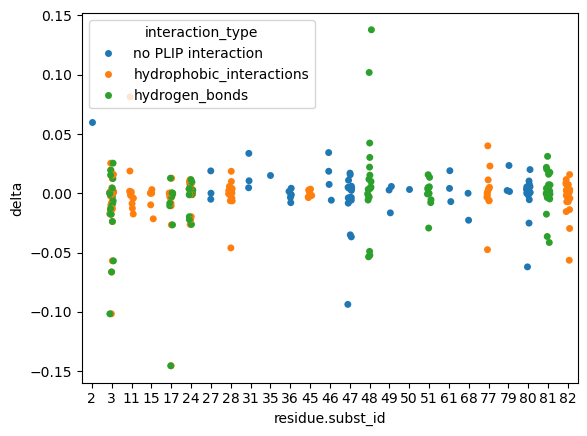

In [18]:
sns.stripplot(deltas_plip, y='delta', x='residue.subst_id', hue='interaction_type')

## KLIFS

In [19]:
bitvec = lambda mask: np.array([c == '1' for c in mask])

In [20]:
@functools.cache
def klifs_encoding():
    resp = req.get('https://klifs.net/api_v2/interactions_get_types')
    
    encodings = dict()
    for entry in resp.json():
        key = ['0'] * 7
        key[int(entry['position']) - 1] = '1'
        encodings[''.join(key)] = entry['name']

    return encodings

In [21]:
@functools.cache
def klifs_ifp(klifs_id):
    resp = req.get('https://klifs.net/api_v2/interactions_get_IFP', {'structure_ID': klifs_id})
    resp.raise_for_status()
    ifp = resp.json()[0]['IFP']
    interactions = []
    residues = []
    for i in range(85):
        res_interactions = bitvec(ifp[i * 7:i * 7 + 7])
        for mask, interaction in klifs_encoding().items():
            if np.any(bitvec(mask) & res_interactions):
                residues.append(i)
                interactions.append(interaction)
    return pd.DataFrame({'residue': residues, 'klifs_interaction': interactions})

In [22]:
ifp = klifs_ifp(df.loc[ident]['similar.klifs_structure_id'])
ifp

,residue,klifs_interaction
0,2,Apolar contact
1,10,Apolar contact
2,14,Apolar contact
3,16,Apolar contact
4,23,Apolar contact
5,23,Hydrogen bond acceptor (protein)
6,26,Apolar contact
7,27,Apolar contact
8,30,Apolar contact
9,34,Apolar contact


In [23]:
deltas_klifs = deltas.merge(ifp, left_on='residue.subst_id', right_on='residue', how='left')
deltas_klifs.fillna({'klifs_interaction': 'no KLIFS interaction'}, inplace=True)

<Axes: xlabel='residue.subst_id', ylabel='delta'>

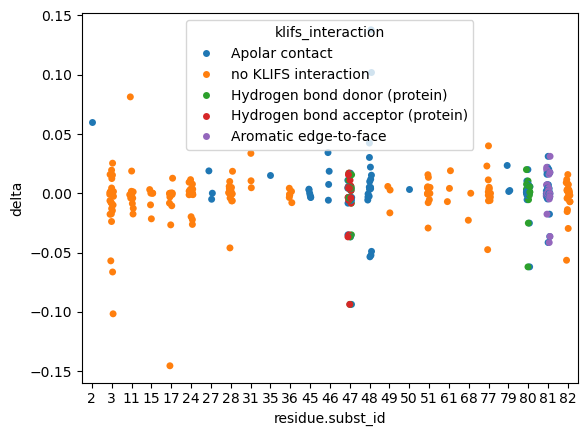

In [24]:
sns.stripplot(deltas_klifs, y='delta', x='residue.subst_id', hue='klifs_interaction')

## Ligand-based analysis

In [25]:
all_deltas = list()
for _, row in tqdm.tqdm(identaids.iterrows(), total=len(identaids)):
    try:
        ident = row['activities.activity_id'] # identaids.set_index('ident').loc[44811]['activities.activity_id']
        demo_data = dataset[key[ident]]
        n_pocket = len(demo_data['pocket']['z'])
        n_ligand = len(demo_data['ligand']['z'])
        
        deltas = pd.read_csv(f'../data/crocodoc_out/delta_{identaids.set_index("activities.activity_id").loc[ident]["ident"]}.csv')
        deltas['ligand_node'] = [max(row['source_node'], row['target_node']) - n_pocket for _, row in deltas.iterrows()]
        ligand_df = pd.DataFrame({'atom_id': np.arange(n_ligand), 'ligand_atom_type': demo_data['ligand']['z']})
        deltas = deltas.merge(ligand_df, left_on='ligand_node', right_on='atom_id')
        
        all_deltas.append(deltas)
    except:
        pass
deltas = pd.concat(all_deltas)



n_pocket = len(pocket_df)
deltas['ligand_node'] = [max(row['source_node'], row['target_node']) - n_pocket for _, row in deltas.iterrows()]
n_ligand = len(demo_data['ligand']['z'])
ligand_df = pd.DataFrame({'atom_id': np.arange(n_ligand), 'ligand_atom_type': demo_data['ligand']['z']})
deltas = deltas.merge(ligand_df, left_on='ligand_node', right_on='atom_id')

<Axes: xlabel='ligand_atom_type', ylabel='delta'>

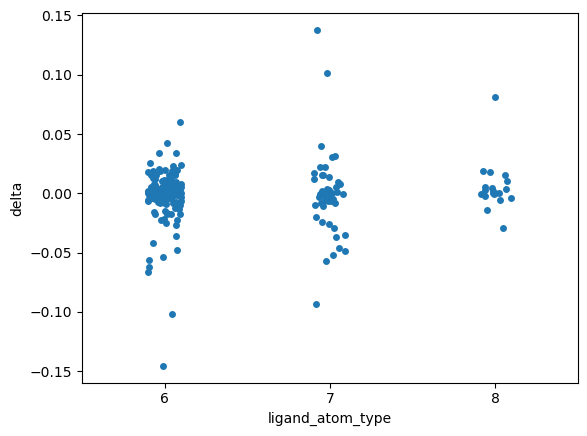

In [26]:
sns.stripplot(deltas, y='delta', x='ligand_atom_type')

## Aggregate

In [27]:
crocodoc_done = pd.read_csv('../data/crocodoc_done.csv', header=None, names=['ident'])

In [28]:
identaids = identaids.merge(crocodoc_done, how='inner')

In [29]:
demo_data

HeteroData(
  y=[1],
  docking_score=[1],
  posit_prob=[1],
  predicted_rmsd=[1],
  pocket_sequence='KPLGRGAFGQVIEVAVKMLALMSELKILIHIGLNVVNLLGAMVIVEFCKFGNLSTYLRSFLASRKCIHRDLAARNILLICDFGLA',
  scaffold='CC(CC1CCCCC1)CC1CCC(CC2CCCC(C3CCCC3)C2)CC1',
  activity_type='pIC50',
  ident=[1],
  smiles='CCNC(=O)c1c[nH]c(-c2cc(Oc3ccc(NC(=O)Nc4cccc(C)c4)cc3)ccn2)c1',
  ligand={
    z=[34],
    x=[34, 12],
    pos=[34, 3],
  },
  pocket={
    z=[652],
    x=[652, 12],
    pos=[652, 3],
  },
  pocket_residue={ x=[85, 23] },
  (ligand, bond, ligand)={
    edge_index=[2, 74],
    edge_attr=[74, 4],
  },
  (pocket, bond, pocket)={
    edge_index=[2, 1308],
    edge_attr=[1308, 4],
  }
)

## Ligand atoms

In [90]:
all_deltas = list()
for _, row in tqdm.tqdm(identaids.iterrows(), total=len(identaids)):
    try:
        ident = row['activities.activity_id'] # identaids.set_index('ident').loc[44811]['activities.activity_id']
        demo_data = dataset[key[ident]]
        n_pocket = len(demo_data['pocket']['z'])
        n_ligand = len(demo_data['ligand']['z'])
        
        deltas = pd.read_csv(f'../data/crocodoc_out/delta_{identaids.set_index("activities.activity_id").loc[ident]["ident"]}.csv')
        deltas['ligand_node'] = [max(row['source_node'], row['target_node']) - n_pocket for _, row in deltas.iterrows()]
        ligand_df = pd.DataFrame({'atom_id': np.arange(n_ligand), 'ligand_atom_type': demo_data['ligand']['z']})
        deltas = deltas.merge(ligand_df, left_on='ligand_node', right_on='atom_id')
        
        all_deltas.append(deltas)
    except:
        pass
deltas = pd.concat(all_deltas)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:01<00:00, 128.48it/s]
/tmp/ipykernel_104782/489119817.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  deltas = pd.concat(all_deltas)


<Axes: xlabel='ligand_atom_type', ylabel='delta'>

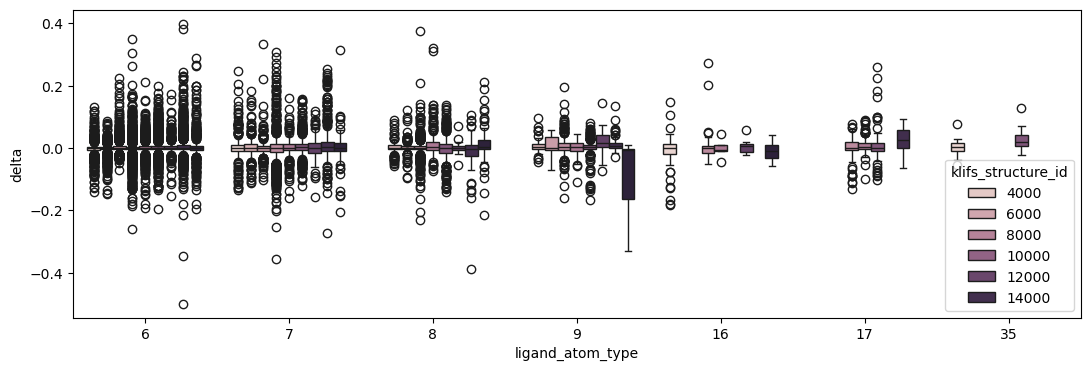

In [93]:
plt.figure(figsize=(13,4))
sns.boxplot(deltas, y='delta', x='ligand_atom_type', hue='klifs_structure_id')

## PL edges

In [32]:
all_deltas = list()
for _, row in tqdm.tqdm(identaids.iterrows(), total=len(identaids)):
    try:
        ident = row['activities.activity_id']
        demo_data = dataset[key[ident]]
        n_pocket = len(demo_data['pocket']['z'])
        n_ligand = len(demo_data['ligand']['z'])
        
        deltas = pd.read_csv(f'../data/crocodoc_out/delta_{identaids.set_index("activities.activity_id").loc[ident]["ident"]}.csv')
        deltas['ligand_node'] = [max(row['source_node'], row['target_node']) - n_pocket for _, row in deltas.iterrows()]
        deltas['pocket_node'] = [min(row['source_node'], row['target_node']) for _, row in deltas.iterrows()]
        ligand_df = pd.DataFrame({'atom_id': np.arange(n_ligand), 'ligand_atom_type': demo_data['ligand']['z']})
        pocket_df = pd.DataFrame({'atom_id': np.arange(n_pocket), 'pocket_atom_type': demo_data['pocket']['z']})
        deltas = deltas.merge(ligand_df, left_on='ligand_node', right_on='atom_id')
        deltas = deltas.merge(pocket_df, left_on='pocket_node', right_on='atom_id')

        all_deltas.append(deltas)
    except:
        pass
deltas = pd.concat(all_deltas)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:02<00:00, 60.04it/s]
/tmp/ipykernel_104782/31920856.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  deltas = pd.concat(all_deltas)


<Axes: xlabel='pocket_atom_type', ylabel='ligand_atom_type'>

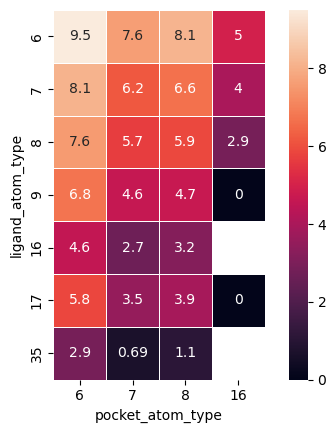

In [33]:
sns.heatmap(deltas.pivot_table(index='ligand_atom_type', columns='pocket_atom_type', values='delta', aggfunc=(lambda x: np.log(len(x)))), annot=True, square=True, linewidths=.5)

<Axes: xlabel='pocket_atom_type', ylabel='ligand_atom_type'>

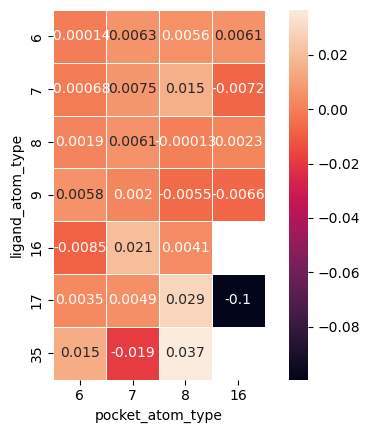

In [34]:
sns.heatmap(deltas.pivot_table(index='ligand_atom_type', columns='pocket_atom_type', values='delta', aggfunc='mean'), annot=True, square=True, linewidths=.5)

<Axes: xlabel='ligand_atom_type', ylabel='pocket_atom_type'>

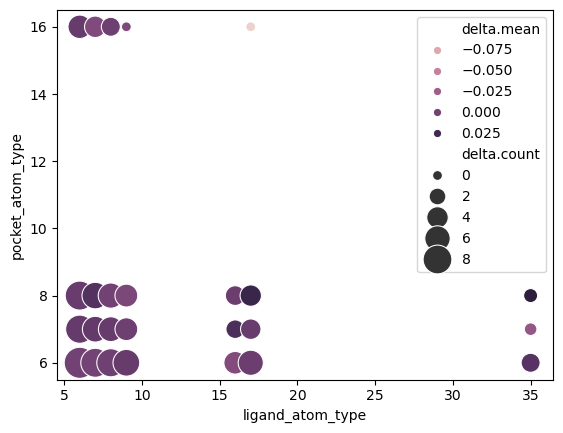

In [35]:
agg_df = deltas.groupby(['ligand_atom_type', 'pocket_atom_type']).agg({'delta': [(lambda x: np.log(len(x))), 'mean']}).reset_index()
agg_df.columns = ['ligand_atom_type', 'pocket_atom_type', 'delta.count', 'delta.mean']
sns.scatterplot(data=agg_df, x='ligand_atom_type', y='pocket_atom_type', size='delta.count', hue='delta.mean', sizes=(50, 500), legend=True)

## Plip interactions

In [38]:
plip_covered_ratio = []
plip_covered_mean = []
plip_not_covered_mean = []
for _, row in tqdm.tqdm(identaids.iterrows(), total=len(identaids)):
    try:
        ident = row['activities.activity_id'] # identaids.set_index('ident').loc[44811]['activities.activity_id']
        demo_data = dataset[key[ident]]
        pocketfile = lambda ident: f'../data/raw/mol2/pocket/{df.loc[ident]["similar.klifs_structure_id"]}_pocket.mol2'
        pocket_df = read_klifs_mol2(pocketfile(ident), with_bonds=False)
        non_hydrogen = pocket_df["atom.type"] != "H"
        pocket_df = pocket_df[non_hydrogen].reset_index()
        pocket_df["atom_id"] = pocket_df.index
        interactions = pd.read_csv(f'../data/interaction_analysis/{ident}.csv')
        
        deltas = pd.read_csv(f'../data/crocodoc_out/delta_{identaids.set_index("activities.activity_id").loc[ident]["ident"]}.csv')
        deltas['pocket_node'] = [min(row['source_node'], row['target_node']) for _, row in deltas.iterrows()]
        deltas = deltas.merge(pocket_df, left_on='pocket_node', right_on='atom_id')
        deltas_plip = deltas.merge(interactions, left_on='residue.subst_id', right_on='residue', how='left')
        plip_covered_ratio.append(1 - deltas_plip['interaction_type'].isna().sum() / len(deltas_plip))
        plip_covered_mean.append(deltas_plip[~deltas_plip['interaction_type'].isna()]['delta'].std())
        plip_not_covered_mean.append(deltas_plip[deltas_plip['interaction_type'].isna()]['delta'].std())
    except:
        pass

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:02<00:00, 54.38it/s]


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb5317a3860>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb532f46b40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb5317a3920>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb532dd4710>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb53044f440>,
 'means': []}

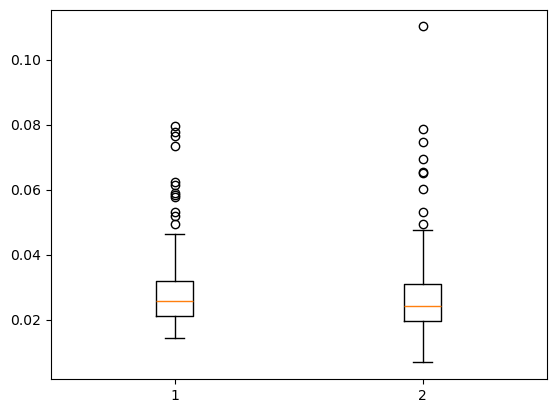

In [39]:
plt.boxplot([[x for x in plip_not_covered_mean if not np.isnan(x)], [x for x in plip_covered_mean if not np.isnan(x)]])

## Bond length

In [76]:
all_deltas = list()
for _, row in tqdm.tqdm(identaids.iterrows(), total=len(identaids)):
    try:
        ident = row['activities.activity_id']
        demo_data = dataset[key[ident]]
        n_pocket = len(demo_data['pocket']['z'])
        n_ligand = len(demo_data['ligand']['z'])
        
        deltas = pd.read_csv(f'../data/crocodoc_out/delta_{identaids.set_index("activities.activity_id").loc[ident]["ident"]}.csv')
        deltas['ligand_node'] = [max(row['source_node'], row['target_node']) - n_pocket for _, row in deltas.iterrows()]
        deltas['pocket_node'] = [min(row['source_node'], row['target_node']) for _, row in deltas.iterrows()]
        ligand_df = pd.DataFrame({'atom_id': np.arange(n_ligand), 'ligand_atom_pos': list(demo_data['ligand']['pos'].detach().numpy())})
        pocket_df = pd.DataFrame({'atom_id': np.arange(n_pocket), 'pocket_atom_pos': list(demo_data['pocket']['pos'].detach().numpy())})
        deltas = deltas.merge(ligand_df, left_on='ligand_node', right_on='atom_id')
        deltas = deltas.merge(pocket_df, left_on='pocket_node', right_on='atom_id')
        
        deltas['edge_length'] = np.sqrt(np.stack((deltas['ligand_atom_pos'] - deltas['pocket_atom_pos'])**2).sum(1))

        all_deltas.append(deltas)
    except:
        pass
deltas = pd.concat(all_deltas)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:02<00:00, 63.53it/s]


In [77]:
deltas

,delta,directed,source_node,target_node,reference,ident,n_pocket,n_ligand,fold,klifs_structure_id,ligand_node,pocket_node,atom_id_x,ligand_atom_pos,atom_id_y,pocket_atom_pos,edge_length
0,0.060291,False,676,12,7.347604,44811,652,34,0,5336,24.0,12.0,24,"[3.4112, 13.4511, 47.0323]",12,"[7.2743, 14.9481, 46.6599]",4.159715
1,-0.023808,False,682,17,7.347604,44811,652,34,0,5336,30.0,17.0,30,"[1.8745, 14.6221, 45.5191]",17,"[5.7411, 16.0385, 44.4989]",4.242357
2,-0.017384,False,676,17,7.347604,44811,652,34,0,5336,24.0,17.0,24,"[3.4112, 13.4511, 47.0323]",17,"[5.7411, 16.0385, 44.4989]",4.305946
3,0.012431,False,682,18,7.347604,44811,652,34,0,5336,30.0,18.0,30,"[1.8745, 14.6221, 45.5191]",18,"[5.6784, 15.2068, 43.1987]",4.493972
4,-0.056968,False,682,19,7.347604,44811,652,34,0,5336,30.0,19.0,30,"[1.8745, 14.6221, 45.5191]",19,"[4.7363, 14.4754, 43.0218]",3.801043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0.000414,True,581,694,7.805476,73968,669,31,0,8668,25.0,581.0,25,"[1.2122, 14.3591, 38.3832]",581,"[-2.7639, 14.1122, 37.4061]",4.101836
150,0.000566,True,635,694,7.805476,73968,669,31,0,8668,25.0,635.0,25,"[1.2122, 14.3591, 38.3832]",635,"[-0.9715, 18.3257, 36.7375]",4.817759
151,-0.003490,True,581,697,7.805476,73968,669,31,0,8668,28.0,581.0,28,"[1.5547, 13.0556, 37.7795]",581,"[-2.7639, 14.1122, 37.4061]",4.461629
152,-0.014207,True,637,697,7.805476,73968,669,31,0,8668,28.0,637.0,28,"[1.5547, 13.0556, 37.7795]",637,"[-0.269, 17.4381, 37.7409]",4.746966


<Axes: xlabel='delta', ylabel='edge_length'>

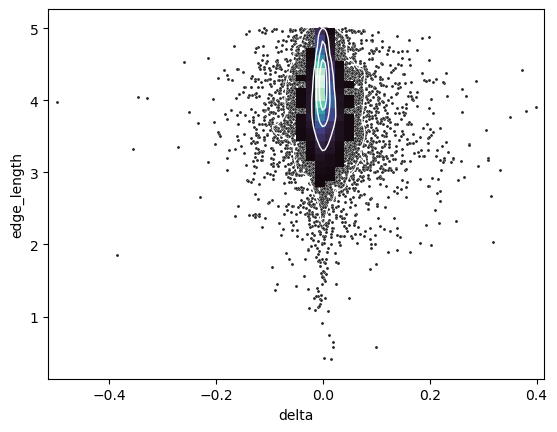

In [86]:
x = deltas['delta']
y = deltas['edge_length']
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

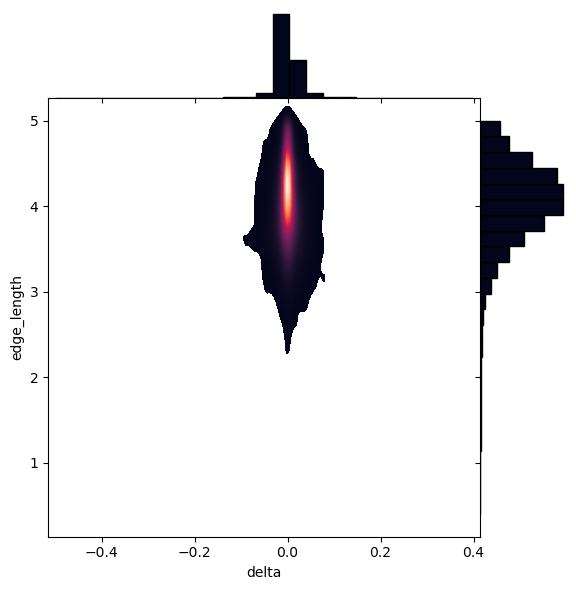

In [88]:
g = sns.JointGrid(data=deltas, x="delta", y="edge_length", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)